*Victoire de Termont, Sarah Jallot and Naomi Serfaty*

This project is an **energy disaggregation problem** on a **time series**, generally known as NILM. From a noisy signal, a household's overall consumption over time, **we aim to predict individual consumption of four appliances, a washing machine, a fridge-freezer, a TV and a kettle, 'non-intrusively'**.
  
Each appliance has a **distinct signature**. This signature depends on user consumption patterns (washing-machine on week-ends for instance), product design (fridge-freezer is nearly always on), and the power each appliance consumes when on (kettle presents high spikes for example). In the **data exploration** phase, we studied the behavior of our appliances  compared to the total electrical consumption of the household on different timescales. It appears that individual appliances bear different relations to consumption depending on whether they are **on or off**, showing that detecting **edges and spikes**  in consumption could be very useful for predictions.   
   
For **feature engineering** and **modelling**, we tested two main approaches. 
- The first was to **engineer features manually to feed into our XGBoost**.  
 We came up with a set of overall good features for a MultiOutput XGBoost, and then improved our predictions by tweaking them into a **relevant set by appliance**, focusing on **fridge** especially as its weight in the custom metric was high. Our features can be regrouped in three categories: weather (temperature, wind and pressure were the ones we kept based on literature research), binary-encoded periodic information (is_teatime, is_winter...), and **consumption transformations** (past and future lags, moving means & std, cumulated sums, etc). We tested each feature to have an idea of relevance, using feature importances of a random forest as an initial subset selector, to then refine. 
- The second was to test a **bidirectional LSTM neural network** based on **consumption only** to predict fridge-freezer, using the results of paper "Neural NILM: Deep Neural Networks Applied to Energy Disaggregation." by J. Kelly, W Knottenbelt et al. The rationale is that a neural network, if well designed, would learn relevant features and dependencies itself.  
You will find below our observations, the functions to code some of the features we thought of, and our model. In an appendix, you will find experiments we led and finally discarded.

On the ENS data challenge platform, our team is called **vicdetermont & naomiserf & sjallot**.

<a id='Imports'></a>
# 1. Import of required libraries, functions and train test data 


Please find in this section only the useful and differenting elements. **We decided to run the whole notebook and then delete what was not useful for the reader, such as imports.** 
We filled consumption NaNs by interpolation, except when over 70% of a rolling day was missing (~2000 observations which we dropped). 
We filled weather NaNs by forward filling on full hours from minute 0 as there were nearly no missing values in minute 0.

In [0]:
 ### imports
import pandas as pd
import datetime as dt
import math as mt
import random
import matplotlib as plt
import seaborn as sns
import numpy as np
from numpy import newaxis
import warnings
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

warnings.filterwarnings("ignore") # may not always be the best thing to do...

import time
import holidays

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Deep learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional
#!pip install -U keras-tuner
from tensorflow import keras
from tensorflow.keras import layers
#from kerastuner.tuners import RandomSearch
import math as mt
import keras.backend as K

Using TensorFlow backend.


In [0]:
## Link colab to your google drive: we worked on Google colab and had access to all our files online
from google.colab import files
import pickle
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Data preprocessing for train test dataset 
def initialise_x_y(url_xtrain, url_ytrain):
  x_train = pd.read_csv(url_xtrain)
  y_train = pd.read_csv(url_ytrain)
  return x_train, y_train

def create_dataframe(x_train, y_train):
  data = pd.concat([x_train,y_train],axis=1,sort=False)
  data = data.loc[:,"consumption":"kettle"] # duplicate time_steps otherwise
  return data

# Get date and time into a readable format + create new features month, day, day of week, hour and minute
def initialisation(df):
  df["time_step"] = pd.to_datetime(df["time_step"])
  # Segmenting periods
  df["month"] = df.apply(lambda x: x["time_step"].month, axis=1)
  df["day"] = df.apply(lambda x: x["time_step"].day, axis=1)
  df["hour"] = df.apply(lambda x: x["time_step"].hour, axis=1)
  df['day_of_week'] = df['time_step'].dt.dayofweek 
  df["minute"] = df.apply(lambda x: x["time_step"].minute, axis=1)
  if "Unnamed: 9" in df.columns:
    df = df.drop(columns={"Unnamed: 9"})
  df.head()
  return df 

# We detected occurrences with many NaNs. We chose to drop observations when we missed more than 70% of a rolling day. 
def delete_many_nans(data,threshold=0.7,period= 60*24 ):
  data["conso_na"] = data["consumption"].isna()
  print(data["conso_na"][0:period].sum())
  b = data[data["conso_na"].rolling(period).sum().fillna(method="bfill") > (threshold*period)]
  return data.drop(b.index)

# Fill NANs in the columns we want to predict, for the train data 
## When we did not drop consumption NaNs. 
def interpolate_consumption(data):
  data['consumption'] = data['consumption'].interpolate(method="linear").fillna(method='bfill')
  data['washing_machine'] = data['washing_machine'].interpolate(method="linear").fillna(method='bfill')
  data['fridge_freezer'] = data['fridge_freezer'].interpolate(method="linear").fillna(method='bfill')
  data['TV'] = data['TV'].interpolate(method="linear").fillna(method='bfill')
  data['kettle'] = data['kettle'].interpolate(method="linear").fillna(method='bfill')
  return data

# Fill weather NANs by fixing minute 0 nans, then forward filling on the hour
def fill_weather(data):
  data_minute_0 = data[data["minute"]==0]
  
  humidity_nans = data_minute_0[data_minute_0["humidity"].isna()]
  humidex_nans  = data_minute_0[data_minute_0["humidex"].isna()]
  windchill_nans  = data_minute_0[data_minute_0["windchill"].isna()]
  wind_nans  = data_minute_0[data_minute_0["wind"].isna()]
  visibility_nans  = data_minute_0[data_minute_0["visibility"].isna()]
  pressure_nans  = data_minute_0[data_minute_0["pressure"].isna()] 
  temperature_nans  = data_minute_0[data_minute_0["temperature"].isna()] 
  monthly_weather = data.groupby("month").mean().loc[:,"consumption":"pressure"].reset_index()
  weather_nans = [humidity_nans, humidex_nans, windchill_nans, wind_nans, visibility_nans, pressure_nans, temperature_nans]
  weather_columns = ["humidity", "humidex", "windchill", "wind", "visibility", "pressure", "temperature"]
  
  keys = monthly_weather["month"].tolist()
  for i in np.arange(len(weather_nans)):
    values = monthly_weather[weather_columns[i]].tolist()
    my_dict = dict(zip(keys, values))
    weather_nans[i][weather_columns[i]] = weather_nans[i]["month"].map(my_dict)
    data_minute_0[weather_columns[i]][data_minute_0[weather_columns[i]].isna()] = weather_nans[i][weather_columns[i]]

  data[data["minute"]==0] = data_minute_0
  
  if np.isnan(data.iloc[0,1]):
    data.iloc[0,1:8] = monthly_weather.iloc[0,1:9]
  data_weather = data.loc[:,"visibility":"pressure"]
  data_weather = data_weather.fillna(method='ffill')
  data.loc[:,"visibility":"pressure"] = data_weather
  return data

In [0]:
# Using all previous functions more efficiently, grouping them together, for train test data 
def preprocess_data(data): 
  data = initialisation(data)
  data = interpolate_consumption(data) 
  data = fill_weather(data)
  return data

In [0]:
# Links to access train test data (not validation data of the platform)
url_xtrain = "https://raw.githubusercontent.com/sarahj134/data_elec_consumption/master/X_train_6GWGSxz.csv"
url_ytrain = "https://raw.githubusercontent.com/sarahj134/data_elec_consumption/master/y_train_2G60rOL.csv"

In [0]:
# Initialise train test dataset and fill missing values
x_train, y_train = initialise_x_y(url_xtrain, url_ytrain)
data = create_dataframe(x_train, y_train)
data = preprocess_data(data)

# 2. Exploratory data analysis

To explore our data, we decided to look at the distribution of given data, and to make graphs of pairs of variables, to understand of correlations could exist.  
We noticed that there were many missing values, and dealt with them in a previous step, defining functions to fill the dataset.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43c6c105f8>,
      dtype=object)

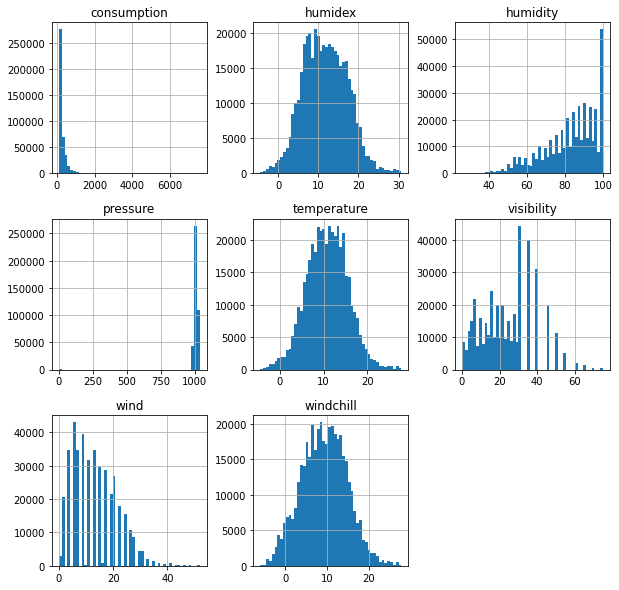

In [0]:
# Plotting the distribution of the given variables that serve as inputs
data.loc[:,"consumption":"pressure"].hist(bins=50, figsize=(10,10), align='mid')

We observe that humidex, temperature and windchill follow Gaussian-like distributions.  
Also, although the scales are quite large, it seems that consumption and pressure both vary within relatively small intervals. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43d1295fd0>,
      dtype=object)

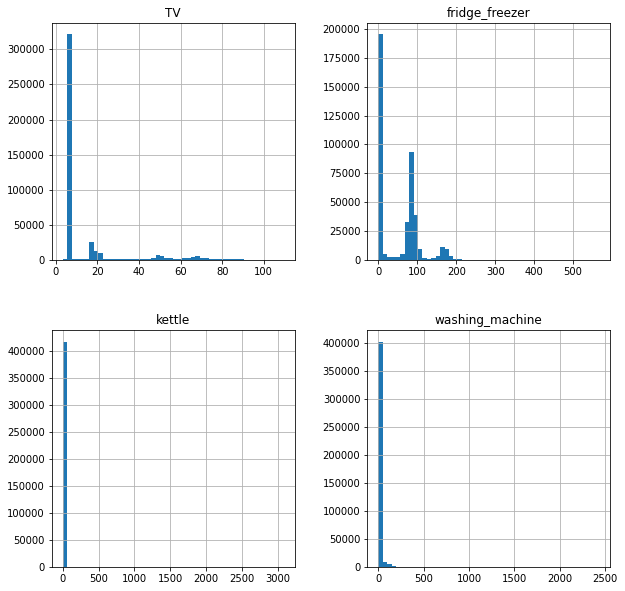

In [0]:
# Plotting the distribution of given variables that serve as inputs
data.loc[:,"washing_machine":"kettle"].hist(bins=50,  figsize=(10,10),align='mid')

We observe that most of the time, the appliances are off.  
That being said, we decided to observe what was happening over time with consumption in general, and for the four appliances. We plotted those variables over time to have a better visualization of what was happening.  

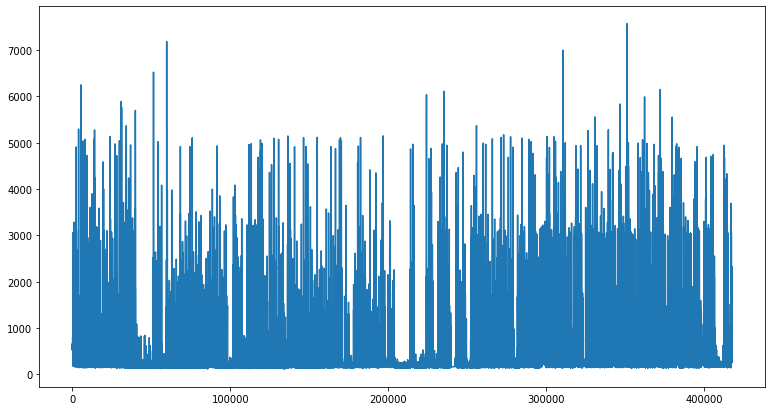

In [0]:
data["consumption"].plot(figsize=(13,7))

Consumption is pretty irregular, with quite long lower periods: we can assume that these correspond to periods where our household is away from home.

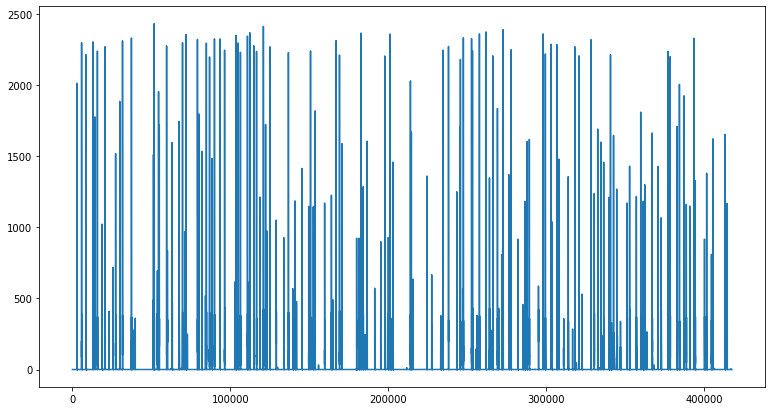

In [0]:
data["washing_machine"].plot(figsize=(13,7))

Washing machine seems to follow a weekly pattern, with peaks corresponding to days in the week. We see no washing machine consumption when overall consumption is low.

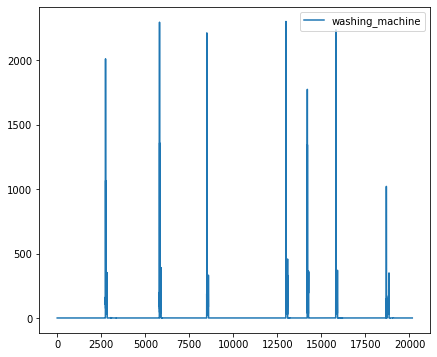

In [0]:
# Zoom on 2 weeks for washing machine
data.loc[:2*60*24*7][['washing_machine']].plot(figsize=(7,6))
plt.show()

We confirm that washing machine can spend several days without being activated at all. The influence of peak hours must also be taken into account, a peak_hours*day_of_week could be interesting to help our model.

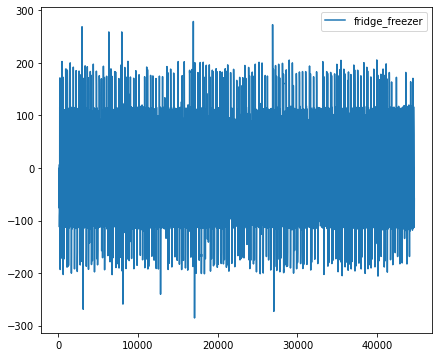

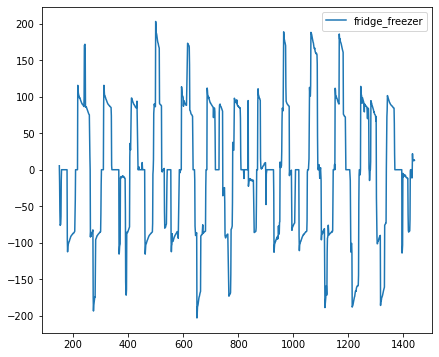

In [0]:
#data["fridge_freezer"].plot(figsize=(13,7)) # total plot does not give more information that the one zooming on one month 

# Zoom on one month for fridge freezer
data.loc[:60*24*31][['fridge_freezer']].diff(150).plot(figsize=(7,6))
plt.show()

# Zoom on one day for fridge freezer
data.loc[:60*24][['fridge_freezer']].diff(150).plot(figsize=(7,6))
plt.show()

Fridge freezer is visually much more regular throughout the observed period. We can assume that the fridge pattern will be observable at a more granular level than washing machine.  
Fridge freezer consumption is dual: the bulk of its consumption stays the same over one or two months, however there are often spikes (probably corresponding to moments when the fridge must cool down).  
With the last graph, we confirm that there is a number of spikes in one day. It could be interesting to take away the average consumption of fridge freezer for each month from consumption to see if this helps our model.

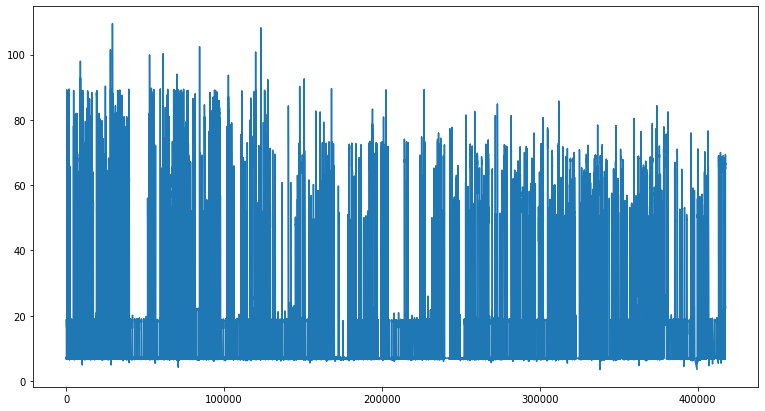

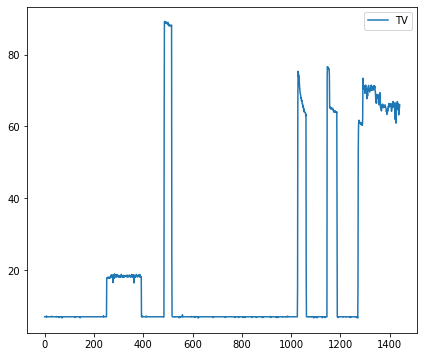

In [0]:
data["TV"].plot(figsize=(13,7))

# One day for TV
data.loc[:60*24][['TV']].plot(figsize=(7,6))
plt.show()

TV presents many spikes, with a low during consumption lows. We can assume it follows more of a daily pattern.   
There are very clear daily spikes in TV consumption, indicating an hourly trend in the target.

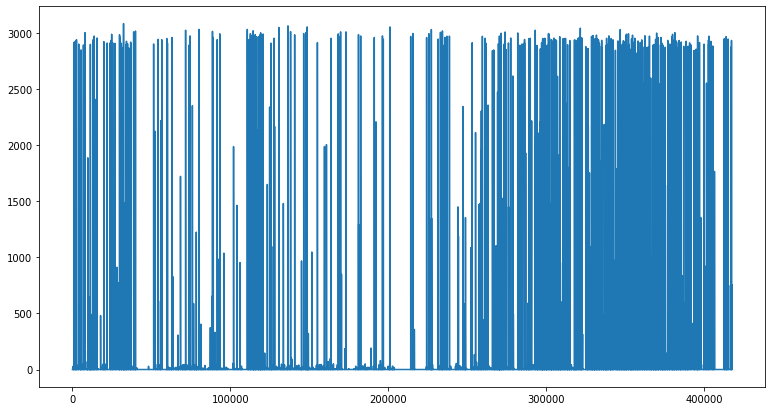

In [0]:
data["kettle"].plot(figsize=(13,7))

Same observation for kettle as for TV: the pattern seems to be daily. We can also see kettle consumption becoming much more frequent towards the end of the time series, corresponding to the colder months. We can assume that people prepare hot food and drinks in the colder months.

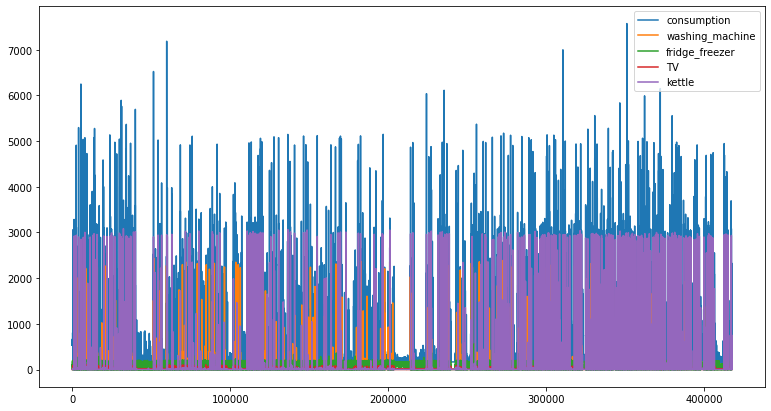

In [0]:
# Plotting all features at once to compare them on the same basis
features = ["consumption", "washing_machine", "fridge_freezer", "TV", "kettle"]
data.loc[:,features].plot(figsize=(13,7))

Plotting all consumptions together, we see:  
- Kettle consumption is the highest when it occurs, and drives overall consumption up. Testing a consumption feature corrected for hourly kettle consumption could be interesting.
- Visually, fridge freezer seems to vary less with consumption but that might be a scale effect. We shall check this when investigating correlations.

Then, we tried to identify time series patterns at different granularity levels.

In [0]:
data.loc[:,["consumption","washing_machine","fridge_freezer","kettle","TV","month"]].groupby("month").mean()

,consumption,washing_machine,fridge_freezer,kettle,TV
month,,,,,
3,361.419421,5.556400,42.320846,4.385925,20.017219
4,296.177572,5.215361,41.389061,3.776446,16.551459
5,283.980685,6.178312,45.784497,1.304619,15.429027
6,274.367403,6.618310,50.552661,3.917128,12.813130
7,248.382001,4.715941,57.546494,1.895366,13.594985
8,223.994448,4.043138,55.848900,1.720263,11.844897
9,281.311602,6.441809,49.565837,3.608603,13.093514
10,363.227440,5.468136,53.266371,8.066695,14.699599
11,381.213867,8.539906,52.057606,13.152962,15.446995


By month : we confirm very clearly that kettle consumption is much higher during colder months: it is highly seasonal.  
We did the same thing by day and then by hour.  
By day : we confirm that the day of the week is relevant to consider when investigating washing machine. For other targets, it is not so clear.  
By hour : we confirm a strong hourly pattern in TV consumption with peaks from hours 18 to 22. Kettle consumption is higher around breakfast and late afternoon/early evening.

Then, we investigated variables and targets together to better understand how they were related.
We expected consumption to be an important feature in terms of correlation to the output, so it should be given a particular attention.

In [0]:
corr_matrix = data.corr()
corr_matrix.round(decimals=2).style.background_gradient(cmap='BuPu')

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute
consumption,1.000000,0.020000,-0.060000,-0.000000,-0.060000,-0.060000,0.030000,-0.020000,0.200000,0.120000,0.180000,0.390000,0.060000,0.000000,0.150000,0.010000,-0.000000
visibility,0.020000,1.000000,0.020000,-0.460000,-0.030000,-0.020000,0.160000,-0.020000,-0.010000,-0.020000,0.000000,0.000000,-0.010000,-0.040000,0.120000,0.010000,-0.000000
temperature,-0.060000,0.020000,1.000000,-0.510000,0.990000,0.980000,0.080000,0.040000,-0.000000,0.070000,-0.010000,-0.010000,-0.240000,0.010000,0.250000,-0.030000,-0.000000
humidity,-0.000000,-0.460000,-0.510000,1.000000,-0.420000,-0.460000,-0.260000,-0.040000,0.000000,-0.000000,-0.030000,0.000000,0.300000,-0.040000,-0.370000,0.040000,-0.000000
humidex,-0.060000,-0.030000,0.990000,-0.420000,1.000000,0.970000,0.060000,0.050000,-0.000000,0.080000,-0.010000,-0.010000,-0.210000,0.010000,0.230000,-0.020000,-0.000000
windchill,-0.060000,-0.020000,0.980000,-0.460000,0.970000,1.000000,-0.100000,0.060000,0.000000,0.080000,-0.020000,-0.010000,-0.230000,-0.000000,0.220000,-0.020000,-0.000000
wind,0.030000,0.160000,0.080000,-0.260000,0.060000,-0.100000,1.000000,-0.080000,-0.020000,-0.000000,0.030000,0.010000,-0.040000,0.060000,0.160000,-0.020000,0.000000
pressure,-0.020000,-0.020000,0.040000,-0.040000,0.050000,0.060000,-0.080000,1.000000,-0.010000,-0.000000,0.000000,-0.000000,-0.050000,0.060000,-0.020000,-0.020000,-0.000000
washing_machine,0.200000,-0.010000,-0.000000,0.000000,-0.000000,0.000000,-0.020000,-0.010000,1.000000,-0.000000,-0.010000,-0.000000,0.000000,-0.010000,0.040000,0.010000,0.000000
fridge_freezer,0.120000,-0.020000,0.070000,-0.000000,0.080000,0.080000,-0.000000,-0.000000,-0.000000,1.000000,0.020000,0.010000,0.040000,-0.030000,0.030000,-0.010000,0.000000


Correlation between consumption and kettle is high, which is coherent with what we observed visually and confirms that investigating normalising kettle consumption in the data could be an option.

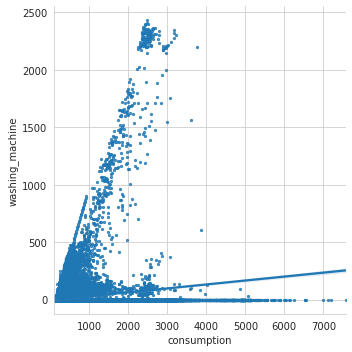

In [0]:
# Washing machine 
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "consumption",
           y = "washing_machine", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

We see very distinctly that **when washing machine is on, it follows a linear relationship with consumption**, but the fact that it can be off warps the linear relation. Detecting its status (on or off) will be key to good predictions. 

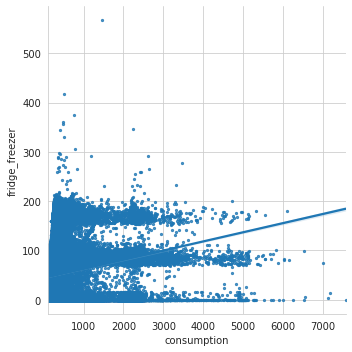

In [0]:
# Fridge_freezer
sns.set_style("whitegrid")
sns_plot = sns.lmplot(x = "consumption",
           y = "fridge_freezer", 
           data = data,  
           legend = True, 
           scatter_kws={"s": 5})

For fridge freezer, there is a clear **level phenomenon, at 0, 100 and 200W**, meaning that detecting these levels could clearly improve our predictions. 

We do not present the other graphs here. The key takeaway is that consumption and each appliance are highly correlated, excepted when the appliance is off, and that we detect levels in target consumption which can be insensitive to overall consumption.
It is very important to note that we face two cases:
- either the appliance is off
- either the consumption / appliance follows a specific distribution.

# 3. Feature construction and selection

As indicated in our introduction, feature engineering was especially directed towards our **XGBoost models**. Our approach was to code functions for each new feature for the sake of clarity.  Then, we tested our features within our model, and used feature selection techniques to guide us when necessary: fitting a random forest for a first feature subset, using sklearn's KBest mode to find potentially useful features based on correlations. Refined pruning and tweaking we did manually. 

For feature engineering and selection, we focused on three variable types: **weather, periodical indicators per appliance, and consumption-derived features**.   

We manually selected **temperature, pressure and wind** out of all weather variables because literature research informed us they were the best predictors of individual consumption.  

Using timestamps, we derived minute, hour, month, day of week easily, and built **new periodical features**: salient periods by appliance (breakfast and teatime for kettle for instance) and season variables (holiday, week-end, winter...) by segmenting the time space. We encoded some of our indicators in cosine and sine format to identify recurring trends (day, hour, day of week). 

Our most useful features overall came from **consumption transformations**.  
From literature research, we first thought of lags and rolling consumption features, both in past and future (expanding consumption didn't prove useful). We then found that normalising consumption could be useful: hence features like consumption minus rolling mean on different periods. Extracting detrended consumption from the seasonal API didn't prove useful (but we did it!). We then thought of using cumulative sums of our normalised consumption features, and differences between steps before and after a given observation. To choose our windows, we grounded our reasoning on both our data exploration (fridge has spikes within 5 minutes, so rolling std would be useful on that window) and literature research (10, 30 minutes are usually good timeframes for fridge as per *Profiling Household Appliance Electricity Usage with N-Gram Language Modeling*, Daoyuan et al). 


In [0]:
# Here is but a small subset of the features we engineered

## Weather variables: we manually selected temperature, wind and pressure. 

## A few examples of seasonal and periodical indicators per appliance.
# Number of days gone by since 1970, catches long term trends in consumption
def add_ndays(data): 
  data['n_days'] = data.loc[:,'time_step'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)
  return data

# Express hours with sine and cosine 
def add_sine_cosine_hour(data):
  hours_in_day = 24
  data['sin_hour'] = np.sin(2*np.pi*data.hour/hours_in_day)
  data['cos_hour'] = np.cos(2*np.pi*data.hour/hours_in_day)
  return data

# Create a table with average hourly consumption per hour
def periodical_avg_consumption_table(data, equipment,period): # period is a string
  avg_hourly_consumption = pd.DataFrame(data.groupby(period).mean().loc[:,equipment])
  avg_hourly_consumption = avg_hourly_consumption.reset_index()
  avg_hourly_consumption.columns = [period,"avg_"+period+"ly_"+equipment]
  return avg_hourly_consumption
# Add average consumption per hour as a feature to your dataframe
def add_periodical_avg_consumption_feature(data, periodical_avg_consumption_table):
  data = data.reset_index().merge(periodical_avg_consumption_table, how="left").set_index('index')
  return data

# Indicate whether the observation occurs during a holiday or not
def add_holiday(data):
  france_holidays = holidays.France()
  data["is_holiday"] = data["time_step"].apply(lambda x: x in france_holidays)*1
  return data

#  Washing machine works more during off-peak. Chose 2 am as lower boundary because consumption is low from 2 to 7 am
def add_peak_hours(data):
  peak_boundaries = [2,21]
  data["peak_hours"] = data.apply(lambda x: (x["hour"]in range(peak_boundaries[0],peak_boundaries[1]))*1, axis=1)
  return data

## A few examples of features based on consumption. 
# Past and future lags. We also experimented with log and exponential lags, but they proved less useful. 
def add_lag(data, lag):
  data["conso - "+str(lag)] = data["consumption"].shift(lag).fillna(method="bfill")
  data["conso + "+str(lag)] = data["consumption"].shift(-lag).fillna(method="ffill")
  return data

# Moving consumption based on the previous n observations (including the one of the current row)
def conso_moving(data, type, n_minutes): # type is a string, in '' 
  data['moving_conso_'+type+'_'+str(n_minutes)]= 0 # initialization 
  last_row = data.shape[0] # to get until the last row 
  # Choose computation type
  if type == 'max':
    data["moving_conso_"+type+'_'+str(n_minutes)] = data["consumption"].rolling(n_minutes).max()
    computation = max
  if type == 'mean':
    data["moving_conso_"+type+'_'+str(n_minutes)] = data["consumption"].rolling(n_minutes).mean()
    computation = mean
  if type == 'min':
    data["moving_conso_"+type+'_'+str(n_minutes)] = data["consumption"].rolling(n_minutes).min()
    computation = min
  if type == "median":
    data["moving_conso_"+type+'_'+str(n_minutes)] = data["consumption"].rolling(n_minutes).median()
    computation = median
  if type == 'std':
    data["moving_conso_"+type+'_'+str(n_minutes)] = data["consumption"].rolling(n_minutes).std()
    computation = std
  # Compute separately the n_minutes first cells. For other functions we used fill backward and forward instead. 
  for i in range(n_minutes):
    data['moving_conso_'+type+'_'+str(n_minutes)][i] = computation(data['consumption'][:n_minutes])

# Adding the moving mean, but with a window in both past and future: 
def add_rolling_mean(data,window):
  n = int(np.floor(int(window)/2))
  data["rolling_mean_"+str(window)] = ((data["consumption"].rolling(n).sum() + data["consumption"].rolling(n).sum().shift(-n))/window).fillna(method="bfill").fillna(method="ffill")
  return data

# Consumption normalised for the moving mean
def add_conso_minus_mvg_conso(data,window):
  data["conso - mvg_avg_"+str(window)] = data["consumption"] - data["moving_conso_mean_"+str(window)]
  return data

# Rolling std in consumption for both past and future
def add_rolling_std(data,window):
  data["rolling_std_past_"+str(window)] = data["consumption"].rolling(window).std().fillna(method="bfill")
  data["rolling_std_future_"+str(window)] = data["consumption"].rolling(window).std().shift(-window).fillna(method="ffill")
  return data

# Expanding consumption: based on the previous n observations (including the one of the current row) 
def conso_expanding(data, n_minutes):
  data["expanding_conso_mean_"+str(n_minutes)] = data["consumption"].expanding(n_minutes).mean()
  data["expanding_conso_max_"+str(n_minutes)] = data["consumption"].expanding(n_minutes).max()
  data["expanding_conso_min_"+str(n_minutes)] = data["consumption"].expanding(n_minutes).min()
  data["expanding_conso_median_"+str(n_minutes)] = data["consumption"].expanding(n_minutes).median()
  data["expanding_conso_std_"+str(n_minutes)] = data["consumption"].expanding(n_minutes).std()
  data.fillna(method="bfill").fillna(method="ffill") # we forward and backward fill the rest of the values to save computing time

# OneHotEncoding of hour, month, day
def one_hot_encode_time_variables(data):
  encoded_variables=["minute", "hour", "day", "day_of_week","month"]
  data_encoded = data.copy()
  for variable in encoded_variables:
    data_encoded = data_encoded.join(pd.get_dummies(data[variable], prefix=variable))
  return data_encoded

To optimize project efficiency, we decided to run all the functions on our train test dataset (called data) and to save it as a CSV file, that we could then use for each new working session on the project. We also encoded the datetime features and saved this new dataframe (will all features from the functions as well) as another CSV, called data_encoded.

In [0]:
# Data with additional features defined above
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data_encoded = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data_encoded.csv")

Then, we used our saved CSV files to select the best features for our model.  
To select a first subset of features, we used sklearn's KBest method based on correlations to the output, our correlation matrix, and feature importances from a RandomForest and our XGBoost. You will find an example below of a graph we obtained at an early stage (sadly some feature names were cut when saving). 

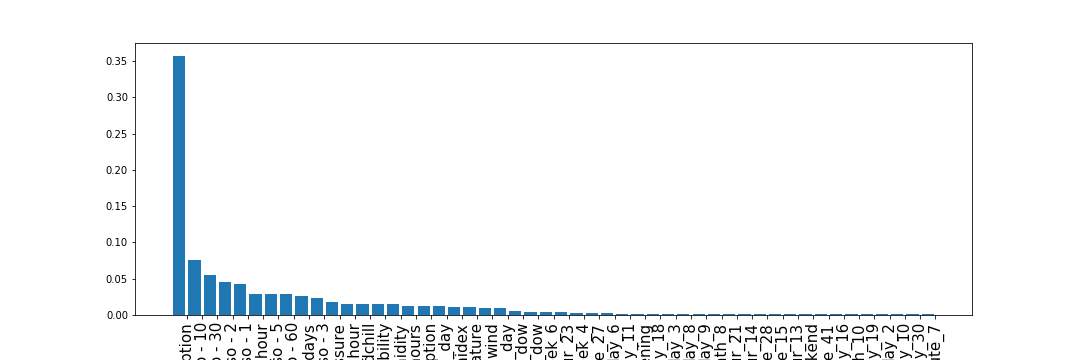

In [0]:
from PIL import Image 
Image.open("/content/gdrive/My Drive/ML2_final_project/feature_importances.png")

At this stage, consumption along with consumption lags for 10 and 30 minutes in the past were very important features. When we run the same code for fridge freezer with our features, rolling_std on 5 minutes is the second most significant feature for instance. 

However, it turned out that this method was very useful to get a first idea of what was interesting to dig into, but not complete to get the best selection possible. So then, we worked together to test features, make a thiner selection. The most important thing was to note our results for each feature and to share them, in order to optimize our time and efficiency. 

# 4. Model selection

We first tried a selection of baseline models with no parameter tuning and our basic features on our data: 4 linear regressions, a Random Forest, a multioutput XGBoost, and a multioutput LGBM. Out of these models, we retained the multioutput XGBoost as our base model. 

We tried two approaches. 
First, we fitted a multioutput xgboost on a good feature subset. This allowed us to get a solid overall performance to rely on. We then fitted an XGBoost per model, tweaking our feature selection, to improve upon our performance for each appliance. Below, you will find an example of tweaking for fridge-freezer, the most difficult appliance to predict and the most weighted one in our metric.  
  
Our second approach was to fit a neural network on just consumption, based on a paper that we had found. 

## 1. Multioutput XGBoost, then a specific XGBoost per appliance (example for fridge freezer) to improve on it specifically. 

In [0]:
# Nilm metric from the challenge
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

In [0]:
# Choosing the features we want to keep
selected_features =  ['consumption', 
                      'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                      'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                      'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                      'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                      'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                      'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                      'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                      'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                      "conso - mvg_avg_10","conso - mvg_avg_30","conso - mvg_avg_60",
                      "conso - mvg_avg_15", "conso - mvg_avg_20",
                      "conso - avg_hourly_kettle",
                      'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'cos_dow', 'sin_dow',
                      'n_days', "hour", "month", "day_of_week",
                      'temperature','pressure',
                      'peak_hours', 
                      'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                      'avg_day_of_weekly_consumption','avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                      'avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                      "conso_anomaly"
                      ]

In [0]:
#Train test Split : we chose not to shuffle the data, but given that we are not using the past to predict the future, we could have
X = data[selected_features]
y = data.loc[:, "washing_machine":"kettle"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [0]:
# Fitting Model
import time
start = time.time()
xgb_reg = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3)
multi_reg = MultiOutputRegressor(xgb_reg,n_jobs=-1)
multi_reg.fit(X_train,y_train)
end = time.time()
print(end-start)

652.6553301811218


In [0]:
# Evaluating our model based on test and train NILM

#Prepare y_pred to be able to use their custom metrics
y_pred = multi_reg.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_df.index = y_test.index

#Prepare y_pred_train to be able to use their custom metrics
y_pred_train = multi_reg.predict(X_train)
y_pred_train_df = pd.DataFrame(y_pred_train)
y_pred_train_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_train_df.index = y_train.index

metric_nilm(y_test, y_pred_df), metric_nilm(y_train, y_pred_train_df) 

(38.79612374025417, 30.684484615474418)

There is some evidence of overfit. We then split our score to analyse our model's strong and weak points. Clearly, focusing on improving fridge freezer was our best bet to improve our score. 

In [0]:
# Fridge freezer
pred = y_pred[:,1]
test = y_test.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

27.18033367860216

In [0]:
# TV
pred = y_pred[:,2]
test = y_test.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

2.980691163686864

In [0]:
# Kettle
pred = y_pred[:,3]
test = y_test.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

5.345492831966233

In [0]:
# Washing machine
pred = y_pred[:,0]
test = y_test.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

3.2896060659989153

We imported the metric-nilm function from the ENS challenge platform, and **adapted the code to test model performance on a single target** during fit as per below (example for fridge freezer).  

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10", 
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60", 
                    # Expanding consumption features were redundant with moving consumption

                    'avg_day_of_weekly_washing_machine','avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                    'avg_day_of_weekly_consumption','avg_day_of_weekly_fridge_freezer',
                    "minutely_std_fridge_freezer",
                    'humidex', 'windchill', 
                    'cos_day', 'sin_day', "day"
                    'moving_conso_max_30', 
                    'avg_hourly_TV','avg_hourly_kettle',
                    ]

In [0]:
features_ff = ['consumption', 
               'conso - 1',  'conso - 30', 'conso - 60', 'conso - 10','conso - 2','conso - 3', 'conso - 5', 
               'conso + 1',  'conso + 30', 'conso + 60', 'conso + 10','conso + 2', 'conso + 3', 'conso + 5',
               'moving_conso_mean_10', 'moving_conso_mean_30', 'moving_conso_mean_60', 
               'moving_conso_min_10','moving_conso_min_60','moving_conso_min_30',
               'moving_conso_std_10', 'moving_conso_std_60','moving_conso_std_30',
               'moving_conso_max_10','moving_conso_max_60',
               'moving_conso_mean_15','moving_conso_mean_20',
               'moving_conso_min_15','moving_conso_min_20',
               'moving_conso_max_15','moving_conso_max_20', 
               "moving_conso_std_15", "moving_conso_std_20", 
               "conso / mvg_std_10", "conso / mvg_std_30","conso / mvg_std_60",
               "conso - mvg_avg_10","conso - mvg_avg_30", "conso - mvg_avg_60",
               "conso - mvg_avg_15", "conso - mvg_avg_20",
               "conso_normalised",
               "conso_normalised_fridge_freezer",  "conso - avg_hourly_fridge_freezer",  "conso - avg_hourly_kettle",
               'cos_hour', 'sin_hour','sin_dow', 'cos_dow',
               "n_days","hour", "month","day_of_week",
               'temperature','pressure', 'wind',
               'peak_hours',
               'avg_hourly_consumption','avg_hourly_fridge_freezer','avg_hourly_washing_machine',
               "conso - rolling_mean_3","conso - rolling_mean_5","conso - rolling_mean_30",
               "rolling_std_future_3", "rolling_std_past_3", "rolling_std_future_5", "rolling_std_past_5", 
               "rolling_std_past_10","rolling_std_future_10", "rolling_std_past_30", "rolling_std_future_30",
               "is_winter", "is_summer",
               "conso_q_25", # using consumption quantiles to detect low and high consumption
               "conso_q_75" 
               ]

In [0]:
# Custom metric to test our performance for a model on fridge freezer only
def custom_metric(y_true, y_pred):
    score = mt.sqrt(sum((y_pred.get_label() - y_true) ** 2) / len(y_true)) * 49.79
    score /= 74.86
    return "nilm", score

In [0]:
X2 = data.loc[:,features_ff]
y2 = data.loc[:, "washing_machine":"kettle"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                        y2, 
                                                        test_size=0.20, 
                                                        shuffle=False)

In [0]:
xgb_reg = XGBRegressor(n_estimators=400,
                       max_depth = 10,
                       learning_rate=0.1)
xgb_reg.fit(X_train2,
            y_train2.iloc[:,1],
            eval_set=[(X_test2, y_test2.iloc[:,1])],
            eval_metric=custom_metric,
            early_stopping_rounds=10)

[18:55:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:66.0297	validation_0-nilm:43.9169
Multiple eval metrics have been passed: 'validation_0-nilm' will be used for early stopping.

Will train until validation_0-nilm hasn't improved in 10 rounds.
[1]	validation_0-rmse:62.0949	validation_0-nilm:41.2998
[2]	validation_0-rmse:58.545	validation_0-nilm:38.9388
[3]	validation_0-rmse:55.5587	validation_0-nilm:36.9526
[4]	validation_0-rmse:53.2214	validation_0-nilm:35.398
[5]	validation_0-rmse:50.8877	validation_0-nilm:33.8458
[6]	validation_0-rmse:48.9361	validation_0-nilm:32.5478
[7]	validation_0-rmse:47.3731	validation_0-nilm:31.5082
[8]	validation_0-rmse:46.032	validation_0-nilm:30.6163
[9]	validation_0-rmse:44.8133	validation_0-nilm:29.8057
[10]	validation_0-rmse:43.8751	validation_0-nilm:29.1817
[11]	validation_0-rmse:43.0024	validation_0-nilm:28.6012
[12]	validation_0-rmse:42.3604	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=400,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

Early stopping is very useful to avoid overfitting. As you can observe looking at previous results, the train error keeps on decreasing, while the test error decreases and then starts increasing again. Early stopping allows us to find the step when test error reaches its minimum - here 79 - and to use it to fit our model.

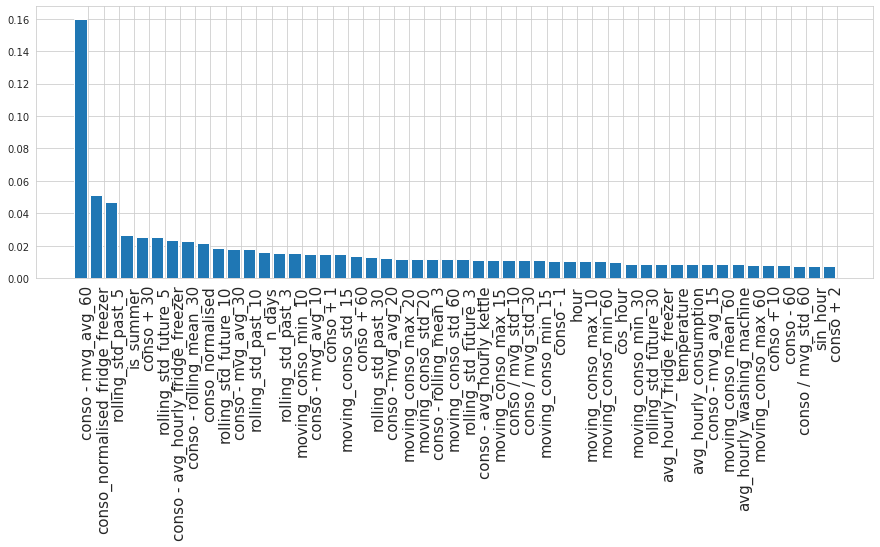

In [0]:
# Looking at the importance of each column and the prediction 
X_columns = X_train2.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb_reg.feature_importances_)[::-1][:50]
importances = xgb_reg.feature_importances_[ordering]
feature_names = X_columns[ordering]
axis = np.arange(len(feature_names))
plt.bar(axis, importances)
plt.xticks(axis + 0.5, feature_names, rotation=90, fontsize=15);

In [0]:
# Metric nilm fridge freezer
pred = xgb_reg.predict(X_test2)
test = y_test2.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

24.978209763148975

Here we can see how our feature tweaking and model parameter choice has improved our predictions on fridge. We then change just our predictions for fridge and submit the result to the platform after fitting on the whole dataset.  
We proceeded in a similar fashion for other appliances: adding consumption anomalies (exploring the data to find consumption peaks) improved our score a lot for washing machine, early stopping did the trick for TV, and kettle was sensitive to the season. 

## 2. Deep learning approach on fridge, as per "Neural NILM: Deep Neural Networks Applied to Energy Disaggregation." by J. Kelly, W. Knottenbelt et al.

We created a light version of our data file to avoid having to download it all at each run. 

In [0]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data_light.csv")
data.head()

,Unnamed: 0,time_step,consumption,fridge_freezer
0,0,2013-03-17 00:01:00,550.4000,79.2000
1,1,2013-03-17 00:02:00,548.6000,78.0000
2,2,2013-03-17 00:03:00,549.3000,76.9000
3,3,2013-03-17 00:04:00,549.3667,76.1111
4,4,2013-03-17 00:05:00,548.8909,75.2727


In [0]:
# Function to reshape the data into batches to feed to our neural network
def reshape_array(data,batch_size): 
  extra_datapoints = data.shape[0]%batch_size
  n_datapoints = data.shape[0]-extra_datapoints
  nb_steps = int(n_datapoints/batch_size)
  nb_features = 1 # for one feature only
  df = data.iloc[extra_datapoints:,] # for one feature only
  return np.array(df).reshape(batch_size,nb_steps,nb_features)

Batch size depends on the chosen window. For fridge, we experimented with 10 and 30 minute batches, but got less good results than on larger batches. So, we settled on training on 3-day batches although it was counter-intuitive.

In [0]:
# Selecting only consumption as a feature
batch_size = 60*24*3 # 3 days
data_train = data.copy().loc[:,"consumption"]
data_target = data.copy().loc[:,"fridge_freezer"]
series_train = reshape_array(data_train,batch_size)
series_target = reshape_array(data_target,batch_size)
print(series_train.shape, series_target.shape)
data_train.head()

(4320, 96, 1) (4320, 96, 1)


0    550.4000
1    548.6000
2    549.3000
3    549.3667
4    548.8909
Name: consumption, dtype: float64

As specified in the paper, we centered consumption by each sample's mean, and normalised it by the standard deviation of a random subsample (the size of a batch).

In [0]:
n_steps = series_train.shape[1]
## Center by the mean of each sample
series_train_centered = (series_train - series_train.mean(axis=0))
## Standard deviation of a random subset of the data. We got lesss good results when normalising so we stopped. 
### Generate std on random subsamples of the data
#random_std = []
for i in np.arange(n_steps):
  random_std.append(np.std(data_train.sample(n=batch_size)))
random_std = np.array(random_std)[:,newaxis]

series_train_norm = series_train_centered / random_std

In [0]:
nb_features = 1 # consumption only
model = tf.keras.Sequential()
model.add(InputLayer(input_shape=[None,nb_features])) # length determined by appliance duration
model.add(Conv1D(filters=16,
                 kernel_size=4, 
                 strides=1, 
                 padding='same', 
                 activation='linear',))
model.add(Bidirectional(LSTM(128, return_sequences=True))) # tf.keras.experimental peephole LSTM raised errors, so we used LSTM only
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.5)) # experimenting by adding a dropout layer to the paper's structure slightly improved our score
model.add(Dense(128, activation="tanh"))
model.add(Dense(n_steps, activation="linear"))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 16)          80        
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         148480    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 96)                12384     
Total params: 1,277,232
Trainable params: 1,277,232
Non-trainable params: 0
_________________________________________________________________


In [0]:
import keras.backend as K
# Custom metric for fit
def custom_metric(y_true, y_pred):
        print(type(y_true))
        print(type(y_pred))
        score = K.sqrt(K.sum(K.cast(y_pred, dtype='float64')  - K.cast(y_true, dtype='float64') ** 2) /  K.cast(tf.size(y_true), dtype='float64') ) * 49.79
        score /= 74.86
        return(score)

In [0]:
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, clipvalue=10)
model.compile(loss=["mse"],
              optimizer=optimizer,
              metrics=[custom_metric])

In [0]:
# Defining the indexes to separate train, validation and test data
end_train_index = int(0.7*batch_size)
end_valid_index = int(0.7*batch_size)+int(0.2*batch_size)


# Defining train, validation and test data
n_steps = int(series_train.shape[1]) # datapoints divided by batch size, minus last step that we want to predict
nb_features = int(series_train.shape[2])

X_train, y_train = series_train_norm[:end_train_index, :n_steps], series_target[:end_train_index, :n_steps] # we want to predict something for each consumption observation
X_valid, y_valid = series_train_norm[end_train_index:end_valid_index, :n_steps], series_target[end_train_index:end_valid_index, :n_steps] 
X_test, y_test = series_train_norm[end_valid_index:, :n_steps], series_target[end_valid_index:, :n_steps]
print(X_train.shape,X_valid.shape, X_test.shape)
print(y_train.shape, y_valid.shape,y_test.shape)

(3024, 96, 1) (864, 96, 1) (432, 96, 1)
(3024, 96, 1) (864, 96, 1) (432, 96, 1)


In [0]:
history = model.fit(X_train, y_train, epochs=8, validation_data=(X_valid,y_valid))

Epoch 1/8
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
95/95 [==============================] - ETA: 0s - loss: 3010.3940 - custom_metric: 0.0000e+00<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
95/95 [==============================] - 5s 51ms/step - loss: 3010.3940 - custom_metric: 0.0000e+00 - val_loss: 2769.6306 - val_custom_metric: 0.0000e+00
Epoch 2/8
95/95 [==============================] - 4s 38ms/step - loss: 2825.1572 - custom_metric: 0.0000e+00 - val_loss: 2774.1182 - val_custom_metric: 0.0000e+00
Epoch 3/8
95/95 [==============================] - 4s 38ms/step - loss: 2828.6318 - custom_metric: 0.0000e+00 - val_loss: 2788.3145 - val_custom_metric: 0.0000e+00
Epoch 4/8
95/95 [==============================] - 4s 38ms/step - loss: 2828.2151 - custom_metric: 0.0000e+00 - val_loss

In [0]:
preds = model.predict(X_test)

In [0]:
from numpy import newaxis
np.sqrt(np.sum((preds[:,:,newaxis] - y_test)**2)/len(y_test.flatten()))*(49.79/74.86)

33.203588724128004

As you can see, the results weren't up to our expectations, and we used the XGBoost's results for fridge.

# 5. Dealing with validation set x_out

As seen before, we defined many function to code new features. As we cannot have access to all information for the x_out, we decided to make predictions of features when necessary. As it takes a long time to run all functions, we did it once and then saved the x_out containing all features as a csv file.  
Find below functions that are specific to the x_out dataset. Then, we decided to directly put here the x_out csv file containing all features. 

In [0]:
# Function to fill NANs 
def interpolate_consumption_only(data):
  data['consumption'] = data['consumption'].interpolate(method="linear").fillna(method='bfill')
  return data

# Preprocess dataset as it has been done on train test dataset 
def preprocess_x_out(data): 
  data = initialisation(data)
  data = interpolate_consumption_only(data) 
  data = fill_weather(data)
  return data

In [0]:
# Initialise validation dataset and fill missing values
url_xout = "https://raw.githubusercontent.com/sarahj134/data_elec_consumption/master/X_test_c2uBt2s.csv"
x_out,_ = initialise_x_y(url_xout, url_ytrain)
x_out_old,_ = initialise_x_y(url_xout, url_ytrain)
x_out = preprocess_x_out(x_out)

As you can imagine, running all functions defined since the beginning takes a lot of time, so used the same technique as for train test dataframe, and below are the CSV files, containing all features, uploaded :

In [0]:
x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out.csv").drop(columns="index")

The last step here is to predict consumptions of the four appliances on our validation set and to create a CSV file that can be uploaded on the platform.  The first step was to code a function to build this CSV file, and the second and last step was to predict results and output the file.

Before submitting our predictions, we applied an **output normalising function**, ensuring for instance that we did not predict negative consumption values. 

In [0]:
# For coherent predictions, we modify our output before submission by making all predictions non-negative. 
def modif_output(y_pred2_df):
  y_pred2_df['kettle'] = y_pred2_df['kettle'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['TV'] = y_pred2_df['TV'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['fridge_freezer'] = y_pred2_df['fridge_freezer'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['washing_machine'] = y_pred2_df['washing_machine'].apply(lambda x : 0 if x<=1 else x)
  return y_pred2_df

In [0]:
# Function to obtain our results in a csv file 
def create_y_predictions(x_out_old, x_out, best_model):
  Y_out_temp = best_model.predict(x_out)
  df = pd.DataFrame(Y_out_temp)
  Y_out = pd.DataFrame(x_out_old["time_step"])
  Y_out["washing_machine"] = df.iloc[:,0]
  Y_out["fridge_freezer"] = df.iloc[:,1]
  Y_out["TV"] = df.iloc[:,2]
  Y_out["kettle"] = df.iloc[:,3]
  Y_out = modif_output(Y_out)
  Y_out.index = Y_out.time_step 
  Y_out.to_csv('y_out.csv', header=True,index=False)
  print(Y_out)
  files.download("y_out.csv")
  return Y_out

In [0]:
# Predicting our results and outputting the CSV file
x_out = x_out[selected_features]
Y_out = create_y_predictions(x_out_old, x_out, multi_reg)

For each individual appliance, we downloaded the best predictions submitted on the platform and modified their column based on the individual XGBoost's predictions. 

# 6. Conclusion and additional information on some attempts

Before elaborating on the strengths and weaknesses of our algorithm, we would like to point out how much we learnt by doing this project. Working with Time Series was almost totally new to us, and we had the opportunity to understand how they worked, and the wide range of particular features that we could use to improve our score. We were very happy to see our model improving step by step, and that it was thanks to new discoveries that could be used for other Time Series projects in the future.

To beginning with the strengths of our project, the first element that should be highlighted is the cooperation and team spirit that we maintained during the whole time. Indeed, we decided to organize the different tasks among the members of our team and to communicate on our results in order to maximize efficiency. Also, we created some files to store our ideas, experiments and results in order to have access to them to the end of the project. It made our work easier and was very appreciated when we had to write the report.  
Also, we decided to each work on a notebook, but to start from the version having the best score every time it was improving on the platform. This allowed us to include all elements of progress with our succesive models, and thus to keep track of amelioration.  

As regards the axes of amelioration, we consider that we could have looked for Time Series - dedicated options sooner. Indeed, we underestimated the difference it made in the beginning, and took a bit of time before looking at the documentation. However, as soon as we started reading articles on Time Series, we had many new ideas and saw our score getting better quite fast. 

In this last section of our project, we would also like to share some ideas that we had, and that turned out to be unsuccessful. Although they haven't been selected in the end, we consider that it is important to show what didn't work and why.
  
One of our ideas was to **use recursive predictions** to improve our model. We thought that predicting consumption per appliance row by row would help the model, as it would have **access to the output of previous rows**. However, this technique was time consuming, which can be a real problem for huge datasets, and didn't give better results.  
  
Also, we added features to understand **time since last activation of appliances and time to next activation, to help the model understand when appliances should be considered on and off**. It could've worked well but added lots of complexity: we had to fit another model to predict these for x_out since they were based on the target, and if model predictions were bad, it threw our model off the target. 
  
Finally, the deep learning approach that we detailed in the model section could have given great results, provided our deep learning literacy was better to understand where we could improve performance.